In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import r2_score
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import randint, uniform

In [4]:
df = pd.read_csv("../data/cleaned/final_merged_dataset.csv")

target = "Cases"
features = [
    'State', 'Crime_Type', 'Year', 'unemployment_rate', 'poverty_rate', 'per_capita_income',
    'inflation_rate', 'population_density', 'gender_ratio', 'literacy_rate',
    'youth_population_percent', 'urbanization_rate', 'human_development_index',
    'police_stations_per_district', 'conviction_rate', 'police_personnel_per_100k',
    'alcohol_consumption_per_capita'
]

numerical_cols = [
    'Year', 'unemployment_rate', 'poverty_rate', 'per_capita_income',
    'inflation_rate', 'population_density', 'gender_ratio', 'literacy_rate',
    'youth_population_percent', 'urbanization_rate', 'human_development_index',
    'police_stations_per_district', 'conviction_rate',
    'police_personnel_per_100k', 'alcohol_consumption_per_capita'
]

categorical_cols = ['State', 'Crime_Type']

train_df = df[df["Year"] <= 2020]
test_df  = df[df["Year"] > 2020]

y_train = train_df[target]
y_test  = test_df[target]

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols)
])

X_train = preprocessor.fit_transform(train_df[features])
X_test  = preprocessor.transform(test_df[features])

print("Shapes:", X_train.shape, X_test.shape)

Shapes: (6300, 59) (630, 59)


In [5]:
print("\nTuning XGB...")
xgb_model = XGBRegressor(random_state=42)

xgb_params = {
    "n_estimators": (150, 500),
    "max_depth": (3, 8),
    "learning_rate": (0.01, 0.05),
    "subsample": (0.7, 0.3),
    "colsample_bytree": (0.7, 0.3)
}

xgb_search = RandomizedSearchCV(
    xgb_model, xgb_params, n_iter=15, scoring='r2',
    cv=3, random_state=42, n_jobs=-1
)
xgb_search.fit(X_train, y_train)
xgb_best = xgb_search.best_estimator_
print("Best XGB:", xgb_search.best_params_)

print("\nTuning LGBM...")
lgb_model = LGBMRegressor(random_state=42)

lgb_params = {
    "n_estimators": (150, 500),
    "num_leaves": (20, 80),
    "learning_rate": (0.01, 0.05),
    "subsample": (0.7, 0.3),
    "colsample_bytree": (0.7, 0.3),
}

lgb_search = RandomizedSearchCV(
    lgb_model, lgb_params, n_iter=15, scoring='r2',
    cv=3, random_state=42, n_jobs=-1
)
lgb_search.fit(X_train, y_train)
lgb_best = lgb_search.best_estimator_
print("Best LGBM:", lgb_search.best_params_)

print("\nTuning RF...")
rf_model = RandomForestRegressor(random_state=42)

rf_params = {
    "n_estimators": (200, 600),
    "max_depth": (10, 30),
    "min_samples_leaf": (1, 4)
}

rf_search = RandomizedSearchCV(
    rf_model, rf_params, n_iter=12, scoring='r2',
    cv=3, random_state=42, n_jobs=-1
)
rf_search.fit(X_train, y_train)
rf_best = rf_search.best_estimator_
print("Best RF:", rf_search.best_params_)

pred_xgb_train = xgb_best.predict(X_train)
pred_lgb_train = lgb_best.predict(X_train)
pred_rf_train  = rf_best.predict(X_train)

pred_xgb_test = xgb_best.predict(X_test)
pred_lgb_test = lgb_best.predict(X_test)
pred_rf_test  = rf_best.predict(X_test)

print("\nSearching best weights...")

weights = np.arange(0.1, 1.0, 0.1)

best_r2 = -999
best_combo = None
best_test_pred = None

for wx in weights:
    for wl in weights:
        wr = 1 - (wx + wl)
        if wr <= 0: 
            continue

        pred_t = wx*pred_xgb_train + wl*pred_lgb_train + wr*pred_rf_train
        r2 = r2_score(y_train, pred_t)

        if r2 > best_r2:
            best_r2 = r2
            best_combo = (wx, wl, wr)
            best_test_pred = wx*pred_xgb_test + wl*pred_lgb_test + wr*pred_rf_test

hybrid_r2 = r2_score(y_test, best_test_pred)
hybrid_rmse = np.sqrt(np.mean((y_test - best_test_pred)**2))
hybrid_mae = np.mean(np.abs(y_test - best_test_pred))

print("\n============================")
print("🔥 Best Hybrid Weights:")
print("XGB :", round(best_combo[0],2))
print("LGBM:", round(best_combo[1],2))
print("RF  :", round(best_combo[2],2))
print("============================")
print("Hybrid R²   :", hybrid_r2)
print("Hybrid RMSE :", hybrid_rmse)
print("Hybrid MAE  :", hybrid_mae)
print("============================")

from sklearn.metrics import mean_squared_error, mean_absolute_error

def get_metrics(y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    return r2, rmse, mae

print("\n================ TRAIN ERRORS ================")

# XGBoost
xgb_r2, xgb_rmse, xgb_mae = get_metrics(y_train, pred_xgb_train)
print("\n📌 XGBoost Train Metrics")
print("R²   :", xgb_r2)
print("RMSE :", xgb_rmse)
print("MAE  :", xgb_mae)

# LightGBM
lgb_r2, lgb_rmse, lgb_mae = get_metrics(y_train, pred_lgb_train)
print("\n📌 LightGBM Train Metrics")
print("R²   :", lgb_r2)
print("RMSE :", lgb_rmse)
print("MAE  :", lgb_mae)

# Random Forest
rf_r2, rf_rmse, rf_mae = get_metrics(y_train, pred_rf_train)
print("\n📌 Random Forest Train Metrics")
print("R²   :", rf_r2)
print("RMSE :", rf_rmse)
print("MAE  :", rf_mae)

# Hybrid
hybrid_train_pred = (
    best_combo[0] * pred_xgb_train +
    best_combo[1] * pred_lgb_train +
    best_combo[2] * pred_rf_train
)

hyb_tr_r2, hyb_tr_rmse, hyb_tr_mae = get_metrics(y_train, hybrid_train_pred)

print("\n Hybrid Model Train Metrics")
print("R²   :", hyb_tr_r2)
print("RMSE :", hyb_tr_rmse)
print("MAE  :", hyb_tr_mae)
print("=============================================")


Tuning XGB...
Best XGB: {'subsample': 0.7, 'n_estimators': 150, 'max_depth': 3, 'learning_rate': 0.05, 'colsample_bytree': 0.3}

Tuning LGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000422 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2797
[LightGBM] [Info] Number of data points in the train set: 6300, number of used features: 59
[LightGBM] [Info] Start training from score 2511.639524
Best LGBM: {'subsample': 0.7, 'num_leaves': 20, 'n_estimators': 150, 'learning_rate': 0.05, 'colsample_bytree': 0.3}

Tuning RF...


c:\Users\gpshu\crime-prediction\venv\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 8 is smaller than n_iter=12. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best RF: {'n_estimators': 600, 'min_samples_leaf': 4, 'max_depth': 10}


c:\Users\gpshu\crime-prediction\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(



Searching best weights...

🔥 Best Hybrid Weights:
XGB : 0.1
LGBM: 0.1
RF  : 0.8
Hybrid R²   : 0.8033706133748874
Hybrid RMSE : 3112.268078217405
Hybrid MAE  : 970.6437496307553

================ TRAIN ERRORS ================

📌 XGBoost Train Metrics
R²   : 0.671320378780365
RMSE : 4681.767828502391
MAE  : 1450.392333984375

📌 LightGBM Train Metrics
R²   : 0.7793535483946469
RMSE : 3835.941367591842
MAE  : 1240.4819994676338

📌 Random Forest Train Metrics
R²   : 0.843299097735816
RMSE : 3232.6540874845814
MAE  : 777.0986100986557

 Hybrid Model Train Metrics
R²   : 0.829209089071399
RMSE : 3374.8607956048636
MAE  : 849.0903183379326


c:\Users\gpshu\crime-prediction\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


In [6]:
import plotly.express as px
import matplotlib.pyplot as plt

weights = {
    "Random Forest (80%)": round(best_combo[2],2),
    "XGBoost (10%)": round(best_combo[0],2),
    "LightGBM (10%)": round(best_combo[1],2),
}

fig_w = px.pie(
    names=list(weights.keys()),
    values=list(weights.values()),
    hole=0.55,
    title="Hybrid Model — Weight Contribution",
)
fig_w.update_traces(textposition='inside', textinfo='label+percent')
fig_w.show()

vis_df = pd.DataFrame({
    "Actual": list(y_test.values),
    "RF_Pred": list(pred_rf_test),
    "XGB_Pred": list(pred_xgb_test),
    "LGBM_Pred": list(pred_lgb_test),
    "Hybrid_Pred": list(best_test_pred)
}).reset_index().head(120)

fig_line = px.line(
    vis_df,
    x="index",
    y=["Actual", "RF_Pred", "XGB_Pred", "LGBM_Pred", "Hybrid_Pred"],
    title="Actual vs Model Predictions — Hybrid is Most Stable"
)
fig_line.show()

error_df = pd.DataFrame({
    "Model": ["Random Forest", "XGBoost", "LightGBM", "Hybrid"],
    "MAE": [rf_mae, xgb_mae, lgb_mae, hyb_tr_mae],
    "RMSE": [rf_rmse, xgb_rmse, lgb_rmse, hyb_tr_rmse]
})

fig_err = px.bar(
    error_df,
    x="Model",
    y=["MAE", "RMSE"],
    barmode="group",
    title="Hybrid vs Base Models — Error Comparison"
)
fig_err.show()

In [7]:
import joblib
import os

os.makedirs("../model", exist_ok=True)

joblib.dump(preprocessor, "../model/hybrid_preprocessor.pkl")

joblib.dump(xgb_best, "../model/xgb_hybrid.pkl")
joblib.dump(lgb_best, "../model/lgbm_hybrid.pkl")
joblib.dump(rf_best,  "../model/rf_hybrid.pkl")

joblib.dump(best_combo, "../model/hybrid_weights.pkl")

print("Saved: hybrid_preprocessor, xgb_hybrid, lgbm_hybrid, rf_hybrid, hybrid_weights")

Saved: hybrid_preprocessor, xgb_hybrid, lgbm_hybrid, rf_hybrid, hybrid_weights


In [8]:
%pip install shap


Note: you may need to restart the kernel to use updated packages.


In [9]:
import shap

In [10]:
feature_names = [
 'numerical__Year',
 'numerical__unemployment_rate',
 'numerical__poverty_rate',
 'numerical__per_capita_income',
 'numerical__inflation_rate',
 'numerical__population_density',
 'numerical__gender_ratio',
 'numerical__literacy_rate',
 'numerical__youth_population_percent',
 'numerical__urbanization_rate',
 'numerical__human_development_index',
 'numerical__police_stations_per_district',
 'numerical__conviction_rate',
 'numerical__police_personnel_per_100k',
 'numerical__alcohol_consumption_per_capita',
 'categorical__State_Andaman & Nicobar Islands',
 'categorical__State_Andhra Pradesh',
 'categorical__State_Arunachal Pradesh',
 'categorical__State_Assam',
 'categorical__State_Bihar',
 'categorical__State_Chandigarh',
 'categorical__State_Chhattisgarh',
 'categorical__State_Dadra & Nagar Haveli and Daman & Diu',
 'categorical__State_Delhi',
 'categorical__State_Goa',
 'categorical__State_Gujarat',
 'categorical__State_Haryana',
 'categorical__State_Himachal Pradesh',
 'categorical__State_Jammu & Kashmir',
 'categorical__State_Jharkhand',
 'categorical__State_Karnataka',
 'categorical__State_Kerala',
 'categorical__State_Lakshadweep',
 'categorical__State_Madhya Pradesh',
 'categorical__State_Maharashtra',
 'categorical__State_Manipur',
 'categorical__State_Meghalaya',
 'categorical__State_Mizoram',
 'categorical__State_Nagaland',
 'categorical__State_Odisha',
 'categorical__State_Puducherry',
 'categorical__State_Punjab',
 'categorical__State_Rajasthan',
 'categorical__State_Sikkim',
 'categorical__State_Tamil Nadu',
 'categorical__State_Telangana',
 'categorical__State_Tripura',
 'categorical__State_Uttar Pradesh',
 'categorical__State_Uttarakhand',
 'categorical__State_West Bengal',
 'categorical__Crime_Type_Burglary',
 'categorical__Crime_Type_Dacoity',
 'categorical__Crime_Type_Dowry Deaths',
 'categorical__Crime_Type_Kidnapping & Abduction',
 'categorical__Crime_Type_Murder',
 'categorical__Crime_Type_Rape',
 'categorical__Crime_Type_Riots',
 'categorical__Crime_Type_Robbery',
 'categorical__Crime_Type_Theft'
]

In [11]:
shap.initjs()


Preparing data for SHAP...

Using Hybrid Weights → XGB=0.100, LGBM=0.100, RF=0.800

Computing SHAP values for base models...

Combining SHAP values for HYBRID model...

📌 SHAP Summary Plot (Hybrid Model)


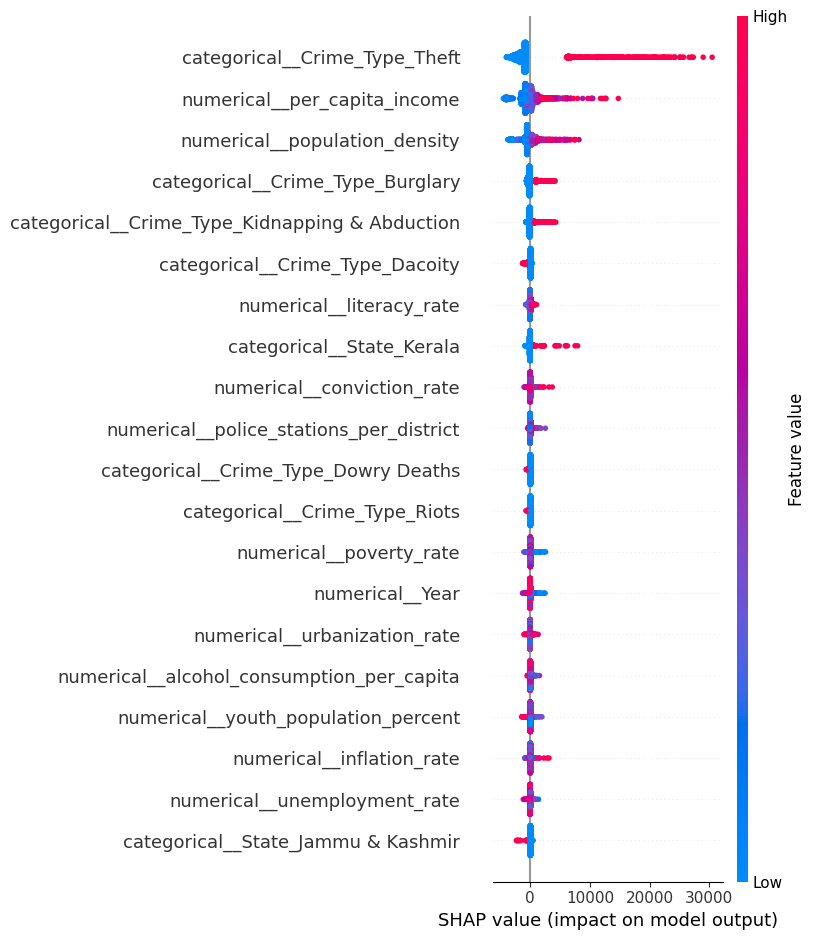


📌 SHAP Bar Plot (Hybrid Model)


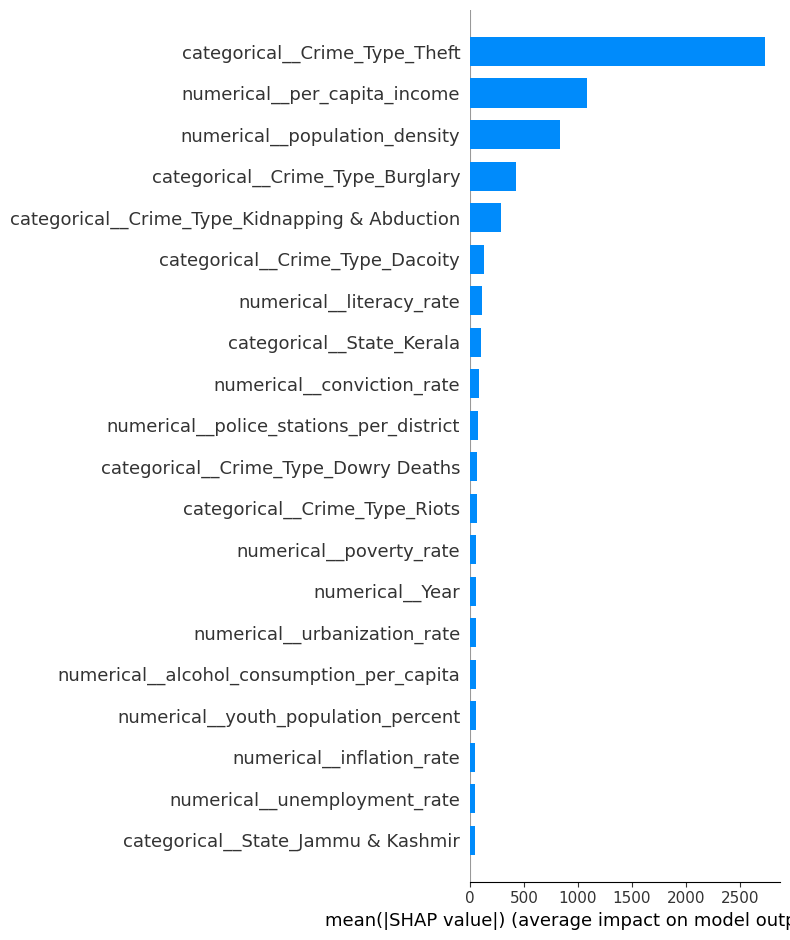

In [12]:
print("\nPreparing data for SHAP...")

X_train_df = pd.DataFrame(X_train, columns=feature_names)

X_sample = X_train_df.sample(3000, random_state=42)

wx, wl, wr = best_combo
print(f"\nUsing Hybrid Weights → XGB={wx:.3f}, LGBM={wl:.3f}, RF={wr:.3f}")

print("\nComputing SHAP values for base models...")

# ---- XGBoost SHAP ----
explainer_xgb = shap.TreeExplainer(xgb_best)
shap_xgb = explainer_xgb.shap_values(X_sample)

# ---- LightGBM SHAP ----
explainer_lgb = shap.TreeExplainer(lgb_best)
shap_lgb = explainer_lgb.shap_values(X_sample)

# ---- Random Forest SHAP ----
explainer_rf = shap.TreeExplainer(rf_best)
shap_rf = explainer_rf.shap_values(X_sample)

print("\nCombining SHAP values for HYBRID model...")

# ---- Hybrid SHAP = weighted sum ----
shap_hybrid = (
    wx * shap_xgb +
    wl * shap_lgb +
    wr * shap_rf
)

print("\n📌 SHAP Summary Plot (Hybrid Model)")
shap.summary_plot(shap_hybrid, X_sample)

print("\n📌 SHAP Bar Plot (Hybrid Model)")
shap.summary_plot(shap_hybrid, X_sample, plot_type="bar")